In [9]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
!pip install albumentations --upgrade
import albumentations
import numpy as np
from IPython.display import clear_output

from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

import sys
sys.path.append("/content/gdrive/My Drive/PyTorch/MiniTorch/")
from minitorch import colab_utils
colab_utils.copy_minitorch_to_local()
from minitorch import datasets
from minitorch.torch_wrapper import TorchWrapper
%load_ext autoreload
%autoreload 2

clear_output()

# Prepare Data

In [13]:
# colab_utils.update_package('torch_wrapper.py')

In [2]:
# Download data
torchvision.datasets.MNIST('/content/images/', train=True, download=True)
torchvision.datasets.MNIST('/images/', train=False, download=True)

# Read in data
X_train, y_train = torch.load('/content/images/MNIST/processed/training.pt')
X_test, y_test = torch.load('/content/images/MNIST/processed/test.pt')

# Combine data
X = np.vstack([X_train.numpy(), X_test.numpy()])
y = np.hstack([y_train.numpy(), y_test.numpy()]).astype(str)

clear_output()

# Load Data

In [3]:
tfm = albumentations.Compose([
  albumentations.Normalize(mean=[0.1307], std=[0.3081], p=1.)
], p=1.)
tfms = {
    'train':tfm,
    'validation':tfm,
    'test':tfm,
    'inference':tfm
}

torch_wrapper = TorchWrapper(X, y, 
                             datasets.MatrixDataset,
                             transforms=tfms,
                             val_size=0.10, test_size=0.10,
                             batch_sizes=(64,-1,-1), num_workers=(0,0,0))

Data is split:
Training shape: ((55999, 28, 28), (55999, 10))
Validation shape: ((7000, 28, 28), (7000, 10))
Testing shape: ((7001, 28, 28), (7001, 10))

Data is loaded into DataLoaders.


# Train New Model

In [4]:
# Using the model architecture found here: https://nextjournal.com/gkoehler/pytorch-mnist

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
torch_wrapper.load_net(net=Net(), weights='equal',
                       chosen_criterion=nn.CrossEntropyLoss, 
                       chosen_optimizer=optim.SGD,
                       chosen_optimizer_params={'lr':0.01, 'momentum':0.5})


Network is loaded.



[1,   150] train_loss: 2.133 | val_loss: 1.423
[1,   300] train_loss: 1.211 | val_loss: 0.550
[1,   450] train_loss: 0.797 | val_loss: 0.371
[1,   600] train_loss: 0.665 | val_loss: 0.305
[1,   750] train_loss: 0.584 | val_loss: 0.263
[2,   150] train_loss: 0.931 | val_loss: 0.210
[2,   300] train_loss: 0.465 | val_loss: 0.187
[2,   450] train_loss: 0.433 | val_loss: 0.174
[2,   600] train_loss: 0.403 | val_loss: 0.158
[2,   750] train_loss: 0.388 | val_loss: 0.154
[3,   150] train_loss: 0.628 | val_loss: 0.139
[3,   300] train_loss: 0.331 | val_loss: 0.131
[3,   450] train_loss: 0.316 | val_loss: 0.121
[3,   600] train_loss: 0.318 | val_loss: 0.124
[3,   750] train_loss: 0.306 | val_loss: 0.118
[4,   150] train_loss: 0.530 | val_loss: 0.112
[4,   300] train_loss: 0.272 | val_loss: 0.109
[4,   450] train_loss: 0.269 | val_loss: 0.109
[4,   600] train_loss: 0.283 | val_loss: 0.100
[4,   750] train_loss: 0.264 | val_loss: 0.096
[5,   150] train_loss: 0.467 | val_loss: 0.090
[5,   300] tr

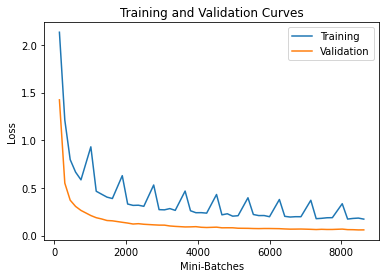

Finished Training


In [6]:
torch_wrapper.train(epochs=10, log_mini_batches=150)

# Load Trained Model (optional)

Loaded epoch10_model.pt in eval mode.



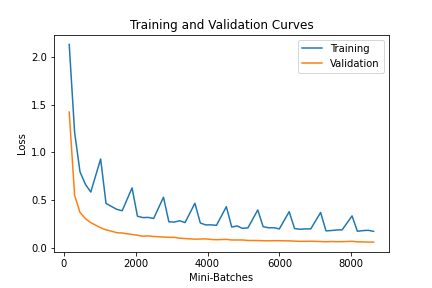

In [16]:
torch_wrapper = TorchWrapper.load_checkpoint(net=Net(), 
                                             checkpoints_path='/content/model_checkpoints/20201206T234629_models/',
                                             model_name='epoch10_model.pt', load_type='eval')

# Evaluate

  1%|          | 8/875 [00:00<00:11, 72.48it/s]

Evaluating Train set...


  0%|          | 0/1 [00:00<?, ?it/s]


Average Train Accuracy: 98.29%
Average Train Hit@N: 0.0

Evaluating Validation set...


  0%|          | 0/1 [00:00<?, ?it/s]


Average Validation Accuracy: 98.21%
Average Validation Hit@N: 0.0

Evaluating Test set...


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]



Average Test Accuracy: 98.14%
Average Test Hit@N: 0.0



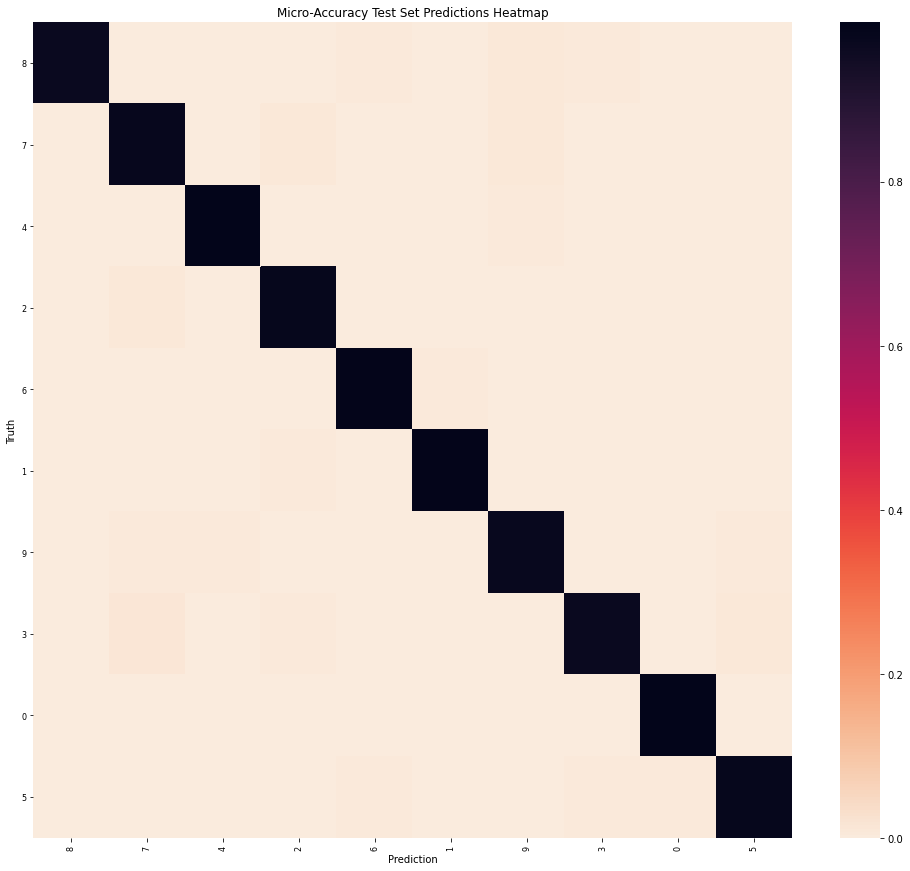

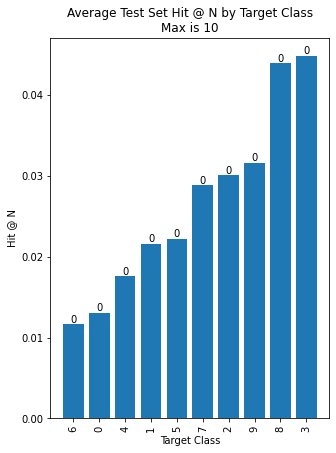

In [17]:
# TODO: Show correct and incorrect predictions, with transforms
# TODO: refactor evaluation process
torch_wrapper.evaluate()